## imports

In [421]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder

import shap
import optuna
import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from geopy.geocoders import Nominatim
from geopy import distance

from pycaret.regression import *

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.dpi'] = 200

## get data

In [396]:
raw_train = pd.read_excel('data/Data_Train.xlsx')
raw_test = pd.read_excel('data/Test_set.xlsx')
raw_sub = pd.read_excel('data/Sample_submission.xlsx')

In [4]:
print(raw_train.info())
raw_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
2276,Air India,15/05/2019,Kolkata,Banglore,CCU → DEL → COK → BLR,10:00,13:45 16 May,27h 45m,2 stops,No info,16057
8136,IndiGo,3/05/2019,Chennai,Kolkata,MAA → CCU,14:45,17:05,2h 20m,non-stop,No info,3858
503,Air India,6/06/2019,Delhi,Cochin,DEL → BOM → COK,13:00,19:15,6h 15m,1 stop,No info,8372


In [5]:
print(raw_test.info())
raw_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
412,Jet Airways,24/05/2019,Kolkata,Banglore,CCU → DEL → BLR,17:00,18:00 25 May,25h,1 stop,No info
2653,Jet Airways,18/05/2019,Kolkata,Banglore,CCU → BOM → BLR,16:30,22:35,6h 5m,1 stop,In-flight meal not included
1921,Air India,12/06/2019,Kolkata,Banglore,CCU → BOM → AMD → BLR,09:25,05:25 13 Jun,20h,2 stops,No info


## eda

In [6]:
eda = raw_train.copy()
edat = raw_test.copy()

In [12]:
# mask = raw_train.isna().any(axis=1)
mask = raw_train.duplicated()
raw_train.loc[mask].sort_values('Date_of_Journey')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9848,Air India,01/03/2019,Banglore,New Delhi,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,2 stops,No info,17135
7502,SpiceJet,03/03/2019,Banglore,New Delhi,BLR → DEL,20:30,23:20,2h 50m,non-stop,No info,6860
8168,Air India,03/03/2019,Banglore,New Delhi,BLR → DEL,21:10,23:55,2h 45m,non-stop,No info,7591
9631,IndiGo,03/03/2019,Banglore,New Delhi,BLR → DEL,16:55,19:45,2h 50m,non-stop,No info,8855
10275,IndiGo,03/03/2019,Banglore,New Delhi,BLR → DEL,08:30,11:30,3h,non-stop,No info,6860
3135,IndiGo,03/03/2019,Banglore,New Delhi,BLR → DEL,10:05,13:00,2h 55m,non-stop,No info,7648
10115,IndiGo,09/03/2019,Banglore,New Delhi,BLR → DEL,10:05,13:00,2h 55m,non-stop,No info,6860
1704,IndiGo,09/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,6860
9913,Air India,1/04/2019,Kolkata,Banglore,CCU → DEL → COK → BLR,10:00,01:20 02 Apr,15h 20m,2 stops,No info,10408
5042,Air India,1/05/2019,Kolkata,Banglore,CCU → DEL → COK → BLR,10:00,13:45 02 May,27h 45m,2 stops,No info,15164


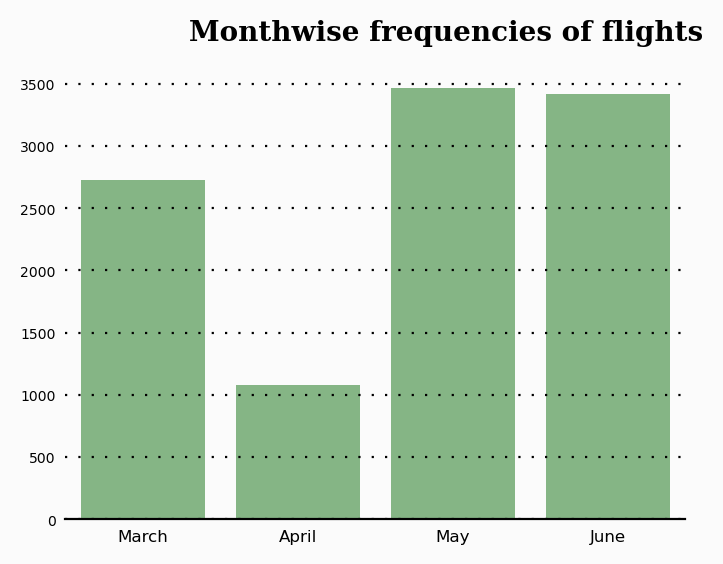

In [16]:
date = raw_train.copy()
date['Date_of_Journey'] = pd.to_datetime(date['Date_of_Journey'], dayfirst=True) 

date['month'] = date['Date_of_Journey'].dt.month
date['year'] = date['Date_of_Journey'].dt.year


background_color = "#fbfbfb"
fig = plt.figure(figsize=(4, 3), facecolor=background_color)
gs = fig.add_gridspec(1, 1)

ax = [None]
ax[0] = fig.add_subplot(gs[:, :])
ax[0].set_facecolor(background_color)

sns.countplot(data=date, x='month', color='green', alpha=0.5)

ax[0].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(1, 5))
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels(['March', 'April', 'May', 'June'], fontsize=6)
# We change the fontsize of minor ticks label 
yticks = ax[0].get_yticks().astype(int)
# print(yticks)
ax[0].set_yticklabels(ytics, fontsize=5)
ax[0].tick_params(axis=u'both', which=u'both',length=0)

for direction in ['top','right','left']:
    ax[0].spines[direction].set_visible(False)
    
ax[0].text(0.3, 3850, 'Monthwise frequencies of flights', 
           fontfamily='Serif', fontweight='bold', fontsize=10)
# ax[0].text(0, -1., 'The samples of business and premium class is quite low.', 
#            fontfamily='Serif', fontsize=12)

plt.show()

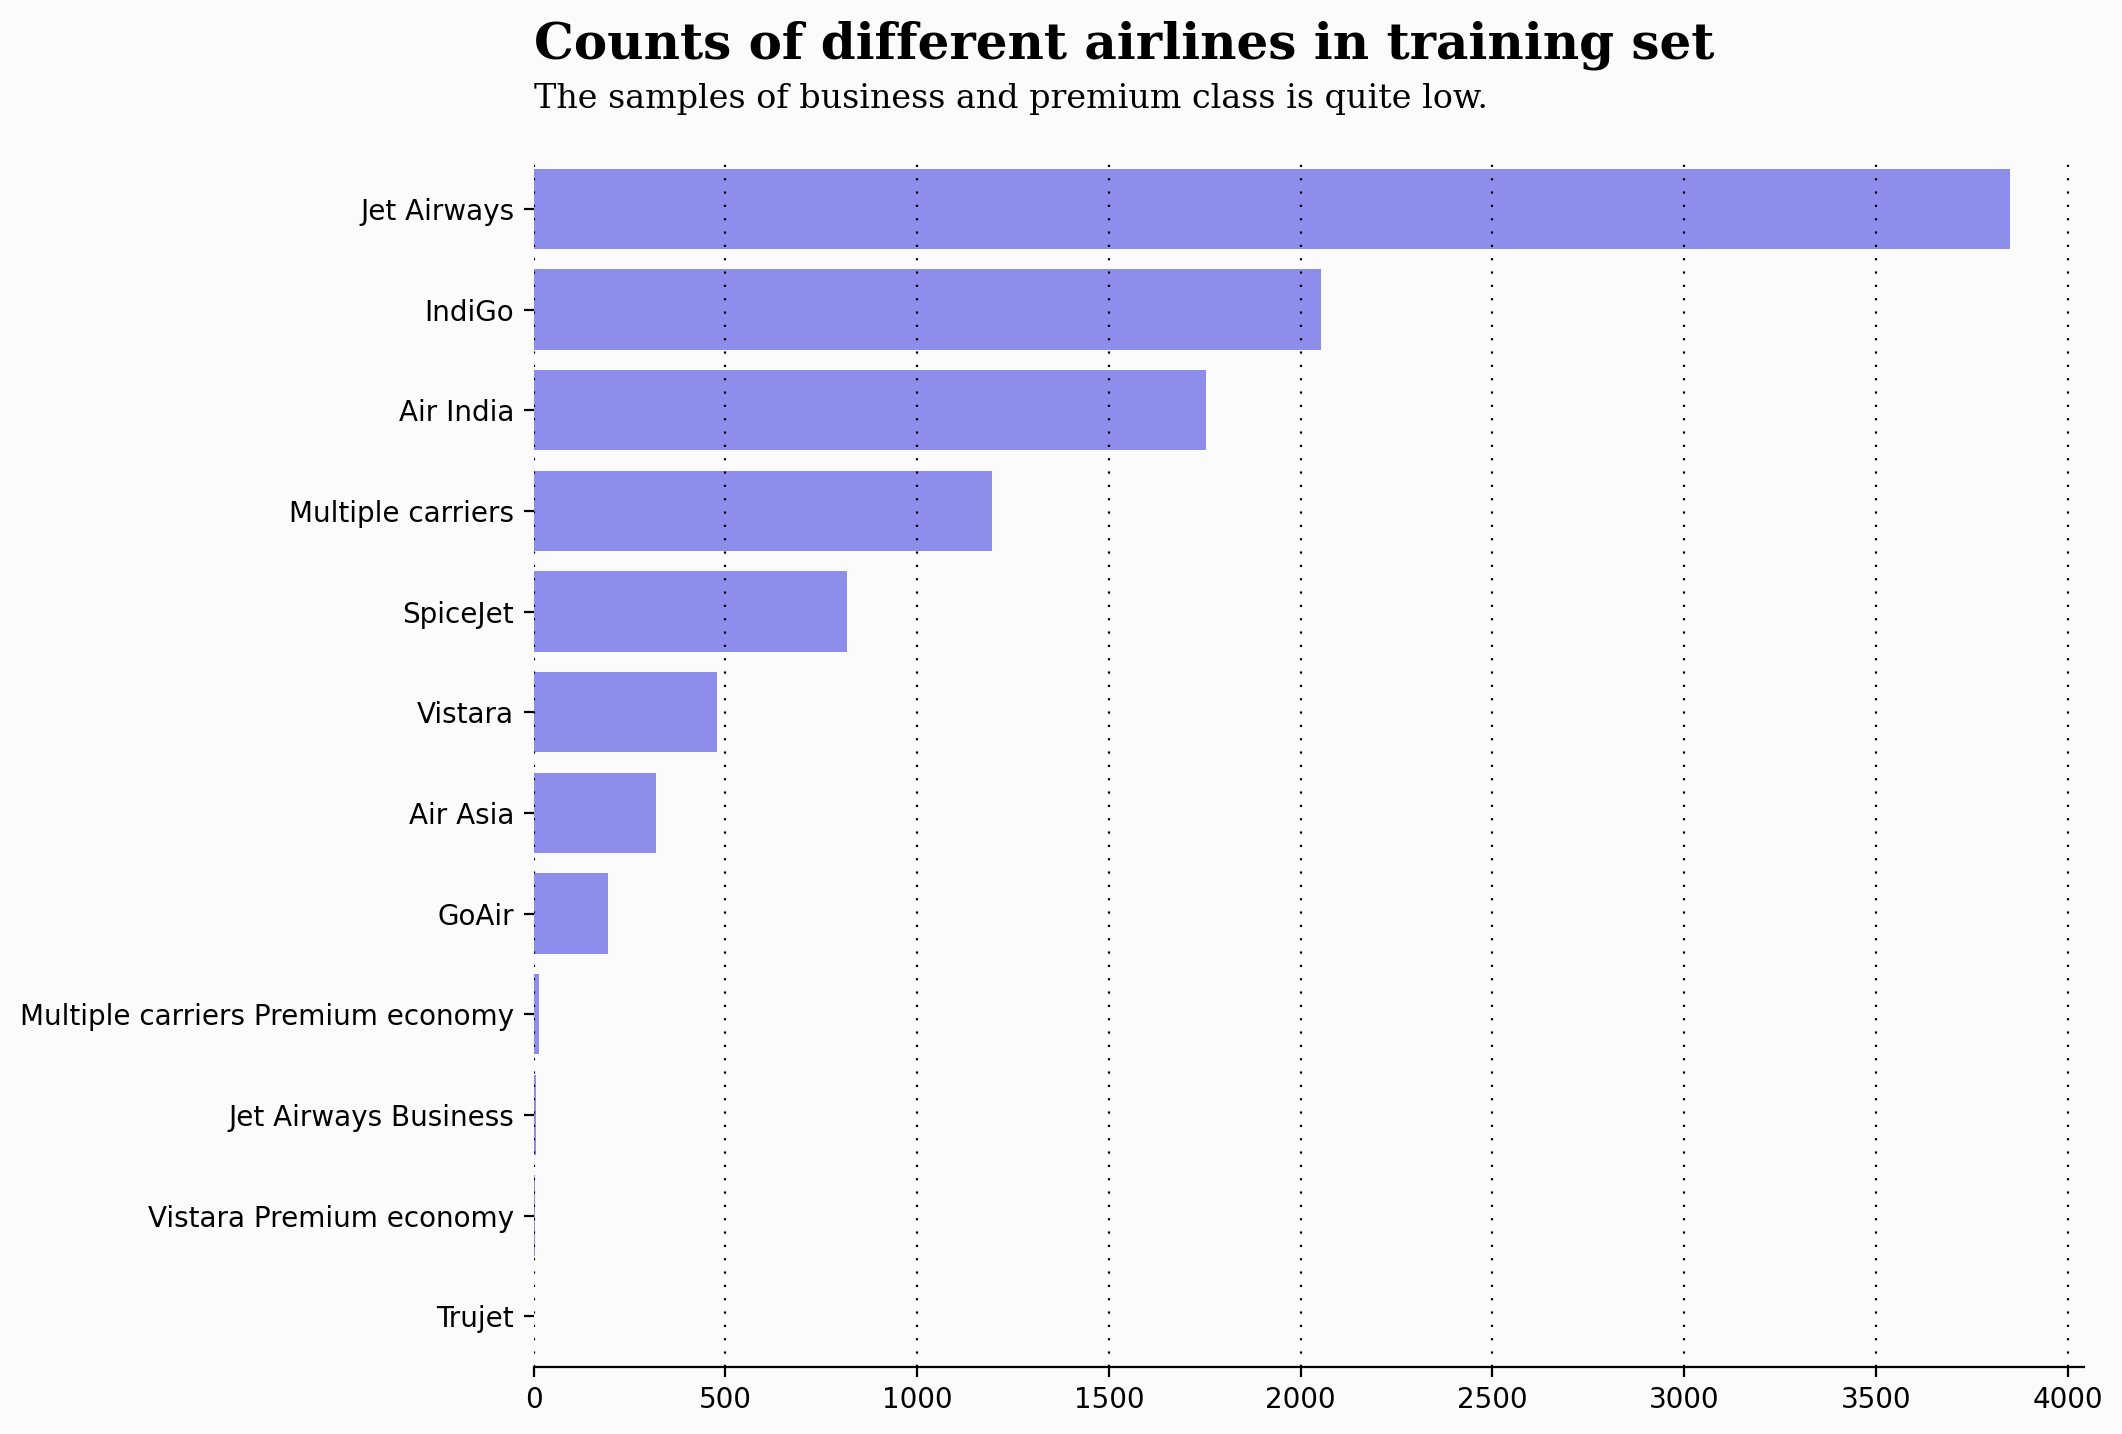

In [61]:
background_color = "#fbfbfb"

fig = plt.figure(figsize=(10, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 1)

ax = [None]
ax[0] = fig.add_subplot(gs[:, :])
ax[0].set_facecolor(background_color)

sns.countplot(data=raw_train, y='Airline', ax=ax[0], 
              order=raw_train['Airline'].value_counts().index, color='blue', alpha=0.5)

ax[0].grid(color='black', linestyle=':', axis='x', zorder=0,  dashes=(1, 5))
ax[0].set_ylabel('')
ax[0].set_xlabel('')

for direction in ['top','right','left']:
    ax[0].spines[direction].set_visible(False)
    
ax[0].text(0, -1.5, 'Counts of different airlines in training set', 
           fontfamily='Serif', fontweight='bold', fontsize=18)
ax[0].text(0, -1., 'The samples of business and premium class is quite low.', 
           fontfamily='Serif', fontsize=12)

plt.show()

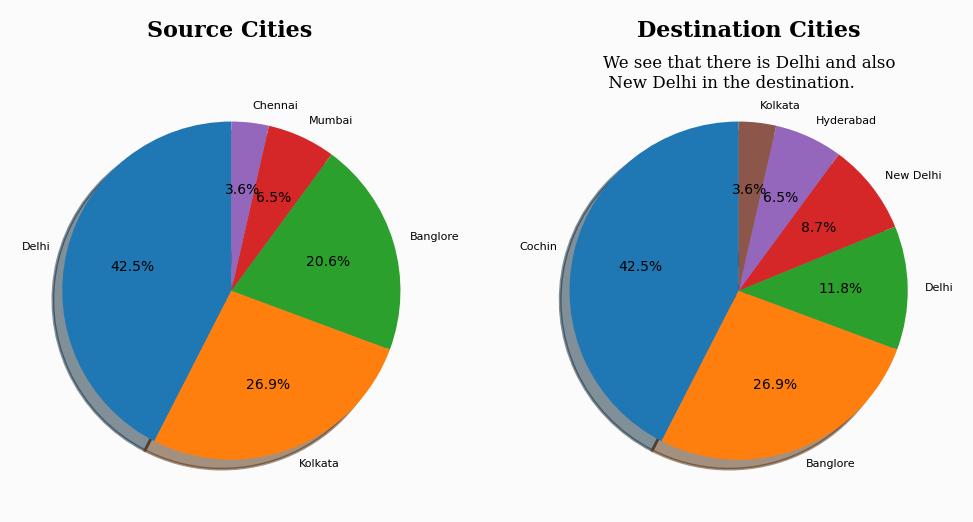

In [164]:
fig = plt.figure(figsize=(6, 6), facecolor=background_color)
gs = fig.add_gridspec(1, 2)

ax = [None for i in range(2)]
ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])

source_city = raw_train['Source'].value_counts()
dest_city = raw_train['Destination'].value_counts()
# source_city

ax[0].pie(source_city.values ,labels=source_city.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax[1].pie(dest_city.values ,labels=dest_city.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax[0].text(-0.5, 1.5, 'Source Cities', fontsize=8, fontweight='bold', fontfamily='serif')
ax[1].text(-0.6, 1.5, 'Destination Cities', fontsize=8, fontweight='bold', fontfamily='serif')

ax[1].text(-0.8, 1.2, 'We see that there is Delhi and also\n New Delhi in the destination.', 
           fontsize=6, fontfamily='serif')

plt.show()

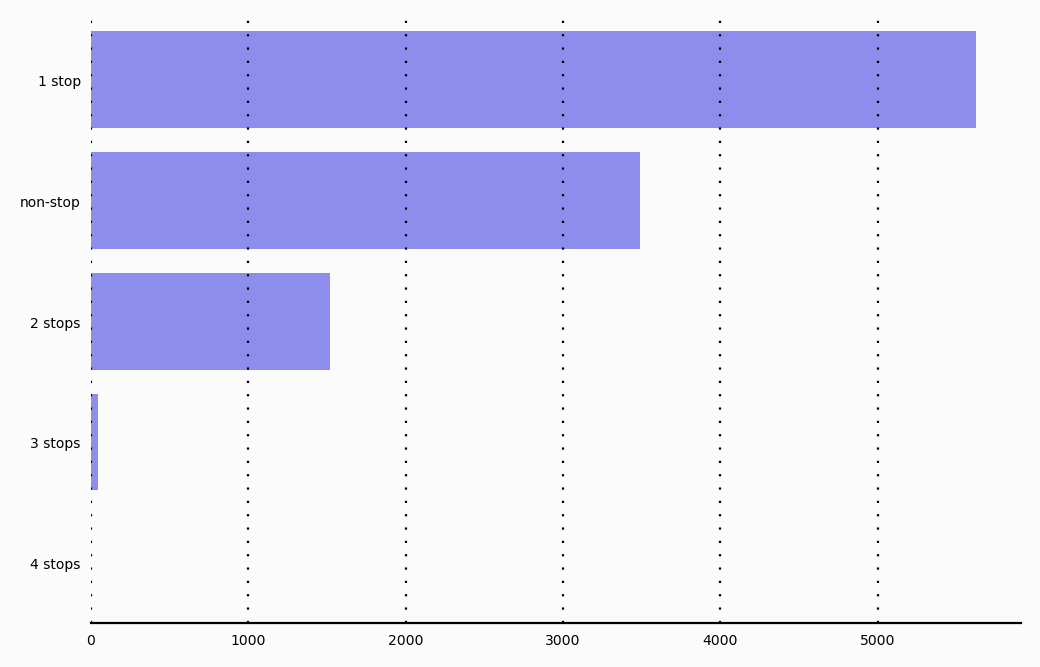

In [34]:
background_color = "#fbfbfb"

fig = plt.figure(figsize=(6, 4), facecolor=background_color)
gs = fig.add_gridspec(1, 1)

ax = [None]
ax[0] = fig.add_subplot(gs[:, :])
ax[0].set_facecolor(background_color)

sns.countplot(data=raw_train, y='Total_Stops', ax=ax[0], 
              order=raw_train['Total_Stops'].value_counts().index, color='blue', alpha=0.5)

ax[0].grid(color='black', linestyle=':', axis='x', zorder=0,  dashes=(1, 5))
ax[0].set_ylabel('')
ax[0].set_xlabel('')

yticks = ax[0].get_yticklabels()
xticks = ax[0].get_xticks().astype(int)
# print(yticks)
ax[0].set_yticklabels(yticks, fontsize=5)
ax[0].set_xticklabels(xticks, fontsize=5)

ax[0].tick_params(axis=u'both', which=u'both',length=0)


for direction in ['top','right','left']:
    ax[0].spines[direction].set_visible(False)
    
# ax[0].text(0, -1.5, 'Counts of different airlines in training set', 
#            fontfamily='Serif', fontweight='bold', fontsize=18)
# ax[0].text(0, -1., 'The samples of business and premium class is quite low.', 
#            fontfamily='Serif', fontsize=12)

plt.show()

In [20]:
raw_train.groupby('Total_Stops').agg(['mean', 'count'])

Price      
                     mean count
Total_Stops                    
1 stop       10594.123556  5625
2 stops      12715.807895  1520
3 stops      13112.000000    45
4 stops      17686.000000     1
non-stop      5024.900315  3491

## preprocess

In [400]:
combine = raw_train.append(raw_test).reset_index(drop=True)
print(combine.shape)
combine.head(3)

(13354, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0


In [419]:
from collections import defaultdict

price_dict = defaultdict(list)
answer = {}

for i, row in tqdm(combine.iterrows(), total=combine.shape[0]):
    key = f"{row['Airline']}_{row['Date_of_Journey']}_{row['Source']}_{row['Destination']}_{row['Dep_Time']}_{row['Duration']}_{row['Total_Stops']}_{row['Additional_Info']}"
    
    if np.isnan(row['Price']):
        if key in price_dict:
            answer[i] = price_dict[key]
    else:
        price_dict[key].append(row['Price'])
    
print(answer)

  0%|          | 0/13354 [00:00<?, ?it/s]

{10686: [14277.0], 10693: [8728.0, 8728.0], 10706: [13029.0], 10724: [13727.0], 10733: [12592.0], 10760: [13899.0], 10784: [7888.0], 10819: [12639.0], 10827: [7648.0], 10844: [6673.0], 10855: [6144.0], 10857: [11885.0], 10873: [13937.0], 10877: [10441.0, 10441.0], 10890: [13014.0, 13292.0, 13292.0], 10924: [13797.0], 10928: [15129.0, 15129.0], 10931: [7933.0], 10933: [18799.0], 10934: [10493.0], 10941: [12819.0, 15339.0], 10948: [6144.0], 10949: [15129.0], 10962: [7222.0], 10977: [13014.0, 13292.0, 13292.0], 10980: [15170.0], 10986: [9385.0], 10995: [14214.0], 11016: [4377.0, 3579.0], 11022: [12392.0, 12199.0], 11024: [11432.0], 11059: [13587.0], 11066: [4777.0, 4777.0], 11080: [6144.0], 11088: [10368.0, 10368.0], 11100: [10368.0], 11129: [13014.0], 11148: [13029.0], 11179: [16704.0, 15129.0], 11180: [11118.0], 11181: [7303.0, 7303.0], 11195: [5575.0, 3925.0], 11204: [16023.0], 11207: [13014.0], 11248: [8656.0], 11263: [4563.0], 11264: [13587.0], 11269: [7530.0], 11271: [7648.0], 11276

In [426]:
price_dict

defaultdict(list,
            {'IndiGo_24/03/2019_Banglore_New Delhi_22:20_2h 50m_non-stop_No info': [3897.0,
              4377.0,
              7303.0],
             'Air India_1/05/2019_Kolkata_Banglore_05:50_7h 25m_2 stops_No info': [7662.0],
             'Jet Airways_9/06/2019_Delhi_Cochin_09:25_19h_2 stops_No info': [13882.0],
             'IndiGo_12/05/2019_Kolkata_Banglore_18:05_5h 25m_1 stop_No info': [6218.0],
             'IndiGo_01/03/2019_Banglore_New Delhi_16:50_4h 45m_1 stop_No info': [13302.0],
             'SpiceJet_24/06/2019_Kolkata_Banglore_09:00_2h 25m_non-stop_No info': [3873.0],
             'Jet Airways_12/03/2019_Banglore_New Delhi_18:55_15h 30m_1 stop_In-flight meal not included': [11087.0],
             'Jet Airways_01/03/2019_Banglore_New Delhi_08:00_21h 5m_1 stop_No info': [22270.0],
             'Jet Airways_12/03/2019_Banglore_New Delhi_08:55_25h 30m_1 stop_In-flight meal not included': [11087.0],
             'Multiple carriers_27/05/2019_Delhi_Cochin_11

In [360]:
combine = combine.drop('Route', axis=1)

In [361]:
combine['hours'] = combine['Duration'].str.extract(pat='(\d+)h').fillna(4).astype(int)
combine['mins'] = combine['Duration'].str.extract(pat='(\d+)m').fillna(0).astype(int)

combine['total_mins'] = combine['hours'] * 60 + combine['mins']

In [362]:
combine = combine.drop(['Duration', 'Arrival_Time', 'hours', 'mins'], axis=1)

In [363]:
combine['dep_hour'] = combine['Dep_Time'].str.split(':').str[0].astype(int)
# combine['dep_min'] = combine['Dep_Time'].str.split(':').str[1].astype(int)

In [364]:
combine['month'] = pd.to_datetime(combine['Date_of_Journey'], dayfirst=True).dt.month
combine['weekday'] = pd.to_datetime(combine['Date_of_Journey'], dayfirst=True).dt.weekday

In [365]:
combine = combine.drop(['Dep_Time', 'Date_of_Journey'], axis=1)

In [366]:
combine['Total_Stops'].value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [367]:
stops_map = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4,
}

combine['Total_Stops'] = combine['Total_Stops'].fillna('1 stop').map(stops_map).astype(int)

In [368]:
mask = combine['Additional_Info'] == 'No Info'
combine.loc[mask, 'Additional_Info'] = 'No info'

In [369]:
info = ['Red-eye flight', '2 Long layover', '1 Short layover']
mask = combine['Additional_Info'].isin(info)
combine = combine.drop(combine.loc[mask].index)

In [207]:
geolocator = Nominatim(user_agent="my_application")

cities = set(combine['Source'].unique().tolist() + combine['Destination'].unique().tolist())
city_coordinates = {}

for c in tqdm(cities, total=len(cities)):
    loc = geolocator.geocode(c)
    city_coordinates[c] = (loc.latitude, loc.longitude)
#     print(c, loc.longitude, loc.latitude)
    
print(city_coordinates)

  0%|          | 0/8 [00:00<?, ?it/s]

{'Delhi': (28.6517178, 77.2219388), 'Banglore': (24.87047205, 67.08472144429825), 'Kolkata': (22.5414185, 88.35769124388872), 'Mumbai': (19.0759899, 72.8773928), 'Chennai': (13.0836939, 80.270186), 'Cochin': (9.9313695, 76.2673759), 'New Delhi': (28.6138954, 77.2090057), 'Hyderabad': (17.360589, 78.4740613)}


In [225]:
distances = []

for i, row in tqdm(combine.iterrows(), total=combine.shape[0]):
    s = row['Source']
    d = row['Destination']
    
    s_c = city_coordinates[s]
    d_c = city_coordinates[d]
    
    dist = distance.distance(s_c, d_c).km
    distances.append(dist)

  0%|          | 0/13351 [00:00<?, ?it/s]

In [370]:
combine['distance'] = distances

In [371]:
mask = combine['Airline'] == 'Trujet'
combine = combine.drop(combine.loc[mask].index)

In [372]:
source_city = pd.get_dummies(combine['Source'], prefix='Source', drop_first=True)
dest_city = pd.get_dummies(combine['Destination'], prefix='Dest', drop_first=True)
add_info = pd.get_dummies(combine['Additional_Info'], drop_first=True)
# airline = pd.get_dummies(combine['Airline'], drop_first=True)

In [373]:
combine = pd.concat([combine, source_city, dest_city, add_info], axis=1)
combine = combine.drop(['Source', 'Destination', 'Additional_Info'], axis=1)

In [374]:
for col in ['Airline']:
    le = LabelEncoder()
    combine[col] = le.fit_transform(combine[col])

In [338]:
combine = combine.drop(['Source', 'Destination'], axis=1)

In [375]:
combine['total_mins'] = np.log(combine['total_mins'])

In [376]:
print(combine.info())
combine.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13350 entries, 0 to 13353
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Airline                       13350 non-null  int64  
 1   Total_Stops                   13350 non-null  int64  
 2   Price                         10679 non-null  float64
 3   total_mins                    13350 non-null  float64
 4   dep_hour                      13350 non-null  int64  
 5   month                         13350 non-null  int64  
 6   weekday                       13350 non-null  int64  
 7   distance                      13350 non-null  float64
 8   Source_Chennai                13350 non-null  uint8  
 9   Source_Delhi                  13350 non-null  uint8  
 10  Source_Kolkata                13350 non-null  uint8  
 11  Source_Mumbai                 13350 non-null  uint8  
 12  Dest_Cochin                   13350 non-null  uint8  
 13  D

,Airline,Total_Stops,Price,total_mins,dep_hour,month,weekday,distance,Source_Chennai,Source_Delhi,...,Dest_Cochin,Dest_Delhi,Dest_Hyderabad,Dest_Kolkata,Dest_New Delhi,Business class,Change airports,In-flight meal not included,No check-in baggage included,No info
0,3,0,3897.0,5.135798,22,3,6,1088.690405,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,2,7662.0,6.098074,5,5,2,2182.476382,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,2,13882.0,7.038784,9,6,6,2074.802124,0,1,...,1,0,0,0,0,0,0,0,0,1
3,3,1,6218.0,5.783825,18,5,6,2182.476382,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,1,13302.0,5.652489,16,3,4,1088.690405,0,0,...,0,0,0,0,1,0,0,0,0,1


In [377]:
mask = combine['Price'].isna()

train = combine.loc[~mask]
test = combine.loc[mask].drop('Price', axis=1)

## pycaret

In [378]:
num_feats = test.columns.tolist()

data_setup = setup(
    data=train,
    target='Price',
    train_size=0.75,
    numeric_features=num_feats,
    transform_target=True,
#     transform_target_method='',
    fold_shuffle=True,
)

,Description,Value
0,session_id,5753
1,Target,Price
2,Original Data,"(10679, 22)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8009, 18)"


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [379]:
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,961.3271,3333795.7500,1825.8685,0.8278,0.1715,0.1065
1,926.5367,3363106.7500,1833.8776,0.8479,0.1603,0.1049
2,814.5306,1882634.1250,1372.0912,0.8902,0.1459,0.0926
3,1029.6338,5184924.5000,2277.0430,0.7784,0.1805,0.1126
4,1024.6743,3760183.2500,1939.1191,0.8340,0.1733,0.1115
5,857.8528,2008246.5000,1417.1261,0.9133,0.1531,0.0987
6,963.4255,3268935.2500,1808.0197,0.8362,0.1730,0.1072
7,959.9708,2844807.2500,1686.6556,0.8570,0.1690,0.1049
8,947.8174,3728810.2500,1931.0127,0.8162,0.1587,0.1022
9,919.7658,3588748.2500,1894.3992,0.8607,0.1547,0.1005


In [244]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,969.0958,3549837.5750,1867.6887,0.8363,0.1712,0.1072,0.8710
catboost,CatBoost Regressor,1057.6884,3597572.3029,1885.5491,0.8339,0.1731,0.1167,1.5270
lightgbm,Light Gradient Boosting Machine,1096.5112,4311263.6323,2053.5987,0.8033,0.1793,0.1214,0.7840
rf,Random Forest Regressor,928.6182,4473195.2600,2082.5800,0.7975,0.1848,0.1030,0.6050
et,Extra Trees Regressor,963.6745,4482388.2803,2103.9648,0.7936,0.2005,0.1095,0.5520
gbr,Gradient Boosting Regressor,1398.8416,5284004.9145,2293.6005,0.7555,0.2106,0.1549,0.2330
dt,Decision Tree Regressor,1083.7516,7062318.7616,2612.8042,0.6816,0.2290,0.1219,0.0350
ada,AdaBoost Regressor,2109.4218,9419356.7281,3055.4002,0.5670,0.3013,0.2636,0.1010
knn,K Neighbors Regressor,1712.8480,9686803.8269,3090.7053,0.5580,0.2592,0.1787,0.1430
lr,Linear Regression,2395.7678,11638460.6000,3407.7201,0.4577,0.3278,0.2731,0.0330


In [380]:
evaluate_model(xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [381]:
final_model = finalize_model(xgb)

In [382]:
preds = predict_model(final_model, data=test)
preds.head()

,Airline,Total_Stops,total_mins,dep_hour,month,weekday,distance,Source_Chennai,Source_Delhi,Source_Kolkata,...,Dest_Delhi,Dest_Hyderabad,Dest_Kolkata,Dest_New Delhi,Business class,Change airports,In-flight meal not included,No check-in baggage included,No info,Label
10683,4,1,6.484635,17,6,3,2074.802124,0,1,0,...,0,0,0,0,0,0,0,0,1,13807.237305
10684,3,1,5.480639,6,5,6,2182.476382,0,0,1,...,0,0,0,0,0,0,0,0,1,4598.579102
10685,4,1,7.261927,19,5,1,2074.802124,0,1,0,...,0,0,0,0,0,0,1,0,0,12588.187500
10686,6,1,6.659294,8,5,1,2074.802124,0,1,0,...,0,0,0,0,0,0,0,0,1,10460.523438
10687,0,0,5.135798,23,6,0,1091.320445,0,0,0,...,1,0,0,0,0,0,0,0,1,4574.014160


In [435]:
for k, v in answer.items():
#     print(k, v)
    preds.loc[k, 'Label'] = v[0]
#     break

In [436]:
preds.head()

,Airline,Total_Stops,total_mins,dep_hour,month,weekday,distance,Source_Chennai,Source_Delhi,Source_Kolkata,...,Dest_Delhi,Dest_Hyderabad,Dest_Kolkata,Dest_New Delhi,Business class,Change airports,In-flight meal not included,No check-in baggage included,No info,Label
10683,4,1,6.484635,17,6,3,2074.802124,0,1,0,...,0,0,0,0,0,0,0,0,1,13807.237305
10684,3,1,5.480639,6,5,6,2182.476382,0,0,1,...,0,0,0,0,0,0,0,0,1,4598.579102
10685,4,1,7.261927,19,5,1,2074.802124,0,1,0,...,0,0,0,0,0,0,1,0,0,12588.187500
10686,14277,14277,14277.000000,14277,14277,14277,14277.000000,197,197,197,...,197,197,197,197,197,197,197,197,197,14277.000000
10687,0,0,5.135798,23,6,0,1091.320445,0,0,0,...,1,0,0,0,0,0,0,0,1,4574.014160


In [433]:
sub = pd.DataFrame({ 'Price': preds['Label'].astype(int) }).reset_index(drop=True)
print(sub.shape)
sub.head()

(2671, 1)


,Price
0,13807
1,4598
2,12588
3,14277
4,4574


In [437]:
sub.to_csv('submissions/pycaret_6.csv', index=False)

  0%|          | 0/10679 [00:00<?, ?it/s]